We import the necessary libraries and set a random seed for repeatability.

In [19]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import numpy as np
import theano
import theano.tensor as T
import cv2
import os
import itertools
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import gzip
import cPickle
from sklearn.externals import joblib

import pylab
from PIL import Image
import matplotlib.cm as cm


#import PIL
#from IPython.display import display, Image

%matplotlib inline
#%pylab inline
rng = np.random.RandomState(12345)    
theano.config.floatX = 'float32'

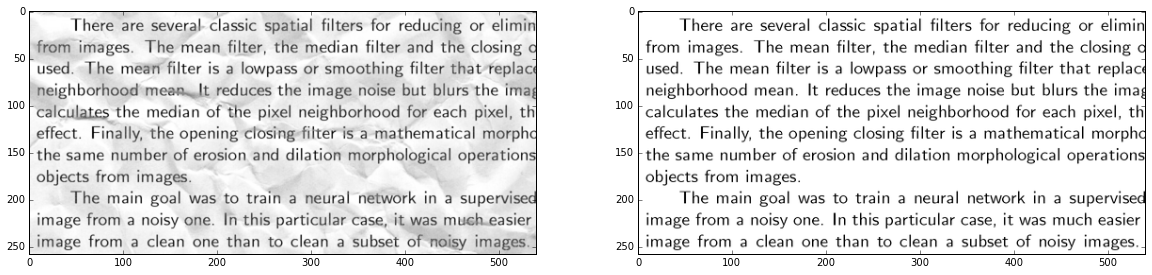

In [21]:
f = pylab.figure(figsize = (20,10))
dirty_im = Image.open('./data/train/48.png','r').convert("L")
clean_im = Image.open('./data/train_cleaned/48.png','r').convert("L")
f.add_subplot(1, 2, 1)
pylab.imshow(dirty_im,cmap=cm.Greys_r)
f.add_subplot(1, 2, 2)
pylab.imshow(clean_im,cmap=cm.Greys_r)

## Processing the Inputs

We define functions to load the training set data, compute features of interest, and generate the target matrix for labels. 

In [22]:
def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [23]:
def feature_matrix(img):
    window = (5,5)
    nbrs = [cv2.getRectSubPix(img, window, (y,x)).ravel() for x,y in itertools.product(range(img.shape[0]), range(img.shape[1]))]
    
    features = np.asarray(nbrs)
    return (features/255.0).astype('float32')

In [24]:
def target_matrix(img):
    return (img/255.0).astype('float32').ravel()[:,None]

In [25]:
def load_train_set(file_list):
    xs = []
    ys = []
    for fname in file_list:
        xs.append(feature_matrix(load_image(os.path.join('./data/train/', fname))))
        ys.append(target_matrix(load_image(os.path.join('./data/train_cleaned/', fname))))
        
    return np.vstack(xs), np.vstack(ys)

We are now ready to load the training and validation data.

In [59]:
all_images = os.listdir('./data/train')
np.random.shuffle(all_images)

train_images = all_images[:int(0.8*len(all_images))]
valid_images = all_images[int(0.8*len(all_images)):]
    
train_x, train_y = load_train_set(train_images)
#train_y = train_y.ravel()
#?? Gotta figure out a solution that works for both RF and NN

In [27]:
def validation_error(valid_images, prediction):
    RMSE = 0
    for fname in valid_images:
        img_x, img_y = load_train_set([fname])
        img_pred = prediction(img_x)
        img_y = img_y.ravel()
        RMSE += np.sqrt(np.mean((img_y - img_pred)**2))
    RMSE = RMSE / len(valid_images)
    return RMSE

In [28]:
def submission_df_from_test_files(test_file_list, prediction):
    num_test_files = len(test_file_list)-1
    i = 0
    submission_df = pd.DataFrame(columns = ["id", "value"])
    for fname in test_file_list:
            if not fname.startswith('.'):
                i = i+1
                if i%5==0:
                    print 'Working on file %i/%i' % (i, num_test_files)

                test_image = load_image(os.path.join('./data/test/', fname))
                test_x = feature_matrix(test_image)        

                y_pred = prediction(test_x)
                size = test_image.shape
                output = y_pred.reshape(size)

                image_number = fname.split(".")[0]
                image_df = pd.DataFrame([(x+1, y+1) for x in range(size[0]) for y in range(size[1])], columns = ["row", "col"])
                image_df['value'] = output[image_df.row-1, image_df.col-1]
                image_df['id'] = image_number + "_" + image_df.row.astype('str') + "_" + image_df.col.astype('str')

                submission_df = submission_df.append(image_df[['id','value']])
    return submission_df    

In [29]:
def write_to_csv_gzip(submission_df):
    with gzip.open('submission.csv.gzip', 'wt') as write_file:
        submission_df.to_csv(write_file, index = False)
        #cv2.imwrite('rf_original_' + fname, test_image)
        #cv2.imwrite('rf_cleaned_' + fname, output)
        
    print "...csv is done!"

## A Simple Random Forest Model

We set a random seed (for repeatability), seperate the images into a training and validation set, and train a random forest classifier. We then use this classifier to predict the test set and output our submission file.

Train Random Forest Classifier

rf = RandomForestRegressor(n_estimators = 10, n_jobs = 2, verbose = 0)
rf.fit(train_x, train_y)

print '...random forest model trained!'

joblib.dump(rf, './models/rf_model.pkl') 
    
print '...random forest model saved!'

In [24]:
#joblib.dump(rf, './models/rf_model.pkl') 
    
#print '...random forest model saved!'

In [12]:
rf = joblib.load('./models/rf_model.pkl') 

print '...random forest model loaded!'

...random forest model loaded!


Compute the validation error

In [13]:
print validation_error(valid_images, rf.predict)

NameError: name 'valid_images' is not defined

Predict the test data

In [14]:
#test_files = ['4.png', '82.png']
test_files = os.listdir('./data/test')

submission_df = submission_df_from_test_files(test_files, rf.predict)

Working on file 5/72
Working on file 10/72
Working on file 15/72
Working on file 20/72
Working on file 25/72
Working on file 30/72
Working on file 35/72
Working on file 40/72
Working on file 45/72
Working on file 50/72
Working on file 55/72
Working on file 60/72
Working on file 65/72
Working on file 70/72


Make output csv.gzip

In [15]:
write_to_csv_gzip(submission_df)

...csv is done!


## Building a Neural Network

We include classes for network layers, the neural network model, and training the neural network.

In [60]:
class Layer(object):
    def __init__(self, inputs, rng, n_in, n_out, W=None, b=None, activation = T.tanh):
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)    
                ),
                dtype = theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value = W_values, name = 'W', borrow = True)
        
        if b is None:
            b_values = np.zeros((n_out,), dtype = theano.config.floatX)
            b = theano.shared(value = b_values, name = 'b', borrow = True)
        
        self.input = inputs
        self.W = W
        self.b = b
        lin_output = T.dot(inputs, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        self.params = [self.W, self.b]

In [61]:
class MLP(object):
    def __init__(self, rng, inputs, n_in, n_hidden, n_out):
        self.hiddenLayer = Layer(
            rng = rng,
            inputs = inputs,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
        )
        
        self.logRegressionLayer = Layer(
            rng = rng,
            inputs = self.hiddenLayer.output,
            n_in = n_hidden,
            n_out = n_out,
            activation = T.nnet.sigmoid
        )
        
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        
        self.input = inputs
        
        self.output = self.logRegressionLayer.output
        
    def cost(self,y):
        return T.mean((self.output - y)**2)

In [65]:
def mlp_train(mlp, training_set, batch_size, learning_rate, n_epochs):
    train_x, train_y = training_set
    
    n_train_batches = train_x.shape[0] // batch_size
    x = mlp.input
    y = T.matrix('y')
    
    gparams = [T.grad(mlp.cost(y), param) for param in mlp.params]
    updates = [(param, param - learning_rate*gparam) for param,gparam in zip(mlp.params, gparams)]
    
    train_model = theano.function(
        inputs = [x,y],
        outputs = [],
        updates = updates
    )
    
    for epoch in xrange(n_epochs):
        for index in range(n_train_batches):
            if index%10000 == 0:
                print 'Batch %i out of %i' % (index, n_train_batches)
            batch = list(range(index*batch_size, (index+1)*batch_size))
            train_model(train_x[batch], train_y[batch])

In [71]:
def mlp_predict(mlp, predict_x):
    x = mlp.input
    predict = theano.function(
        inputs = [x],
        outputs = [mlp.output]
    )
    
    predict_y, = predict(predict_x)
    return predict_y

In [67]:
n_hidden = 10
batch_size = 20
n_epochs = 1
rate = 0.1

x = T.matrix('x')

mlp = MLP(
    rng = rng,
    inputs = x,
    n_in = train_x.shape[1],
    n_hidden = n_hidden,
    n_out = 1
)

mlp_train(mlp, (train_x, train_y), batch_size = batch_size, n_epochs = n_epochs, learning_rate = rate) 

Batch 0 out of 1129140
Batch 100 out of 1129140
Batch 200 out of 1129140
Batch 300 out of 1129140
Batch 400 out of 1129140
Batch 500 out of 1129140
Batch 600 out of 1129140
Batch 700 out of 1129140
Batch 800 out of 1129140
Batch 900 out of 1129140
Batch 1000 out of 1129140
Batch 1100 out of 1129140
Batch 1200 out of 1129140
Batch 1300 out of 1129140
Batch 1400 out of 1129140
Batch 1500 out of 1129140
Batch 1600 out of 1129140
Batch 1700 out of 1129140
Batch 1800 out of 1129140
Batch 1900 out of 1129140
Batch 2000 out of 1129140
Batch 2100 out of 1129140
Batch 2200 out of 1129140
Batch 2300 out of 1129140
Batch 2400 out of 1129140
Batch 2500 out of 1129140
Batch 2600 out of 1129140
Batch 2700 out of 1129140
Batch 2800 out of 1129140
Batch 2900 out of 1129140
Batch 3000 out of 1129140
Batch 3100 out of 1129140
Batch 3200 out of 1129140
Batch 3300 out of 1129140
Batch 3400 out of 1129140
Batch 3500 out of 1129140
Batch 3600 out of 1129140
Batch 3700 out of 1129140
Batch 3800 out of 112914

In [ ]:
print validation_error(valid_images, lambda x: mlp_predict(mlp,x))

##Acknowledgements

Thank the deeplearning.net tutorial plust the guy on the forums.

##Defunct Code

class Layer(object):
    
    def __init__(self, rng, inp, n_in, n_out, activation = T.tanh):
        W_values = rng.uniform(low = -(1.0/(n_in + n_out)),
                               high =(1.0 / (n_in + n_out)),
                               size = (n_in, n_out)).astype('float32')
        self.W = theano.shared(value = W_values, name = 'W', borrow = True)
        b_values = np.zeros((n_out,), dtype = np.float32)
        self.b = theano.shared(value = b_values, name = 'b', borrow = True)
        
        self.input = inp
        self.output = activation(T.dot(self.input, self.W) + self.b)
        self.params = [self.W, self.b]
        

In [7]:
class Model(object):
    def __init__(self, rng, inp, n_in, n_hidden, n_out):
        self.layer1 = Layer(
            rng = rng,
            inp = inp,
            n_in = n_in,
            n_out = n_hidden,
            activation = T.tanh
        )
        
        self.layer2 = Layer(
            rng = rng,
            inp = self.layer1.output,
            n_in = n_hidden,
            n_out = n_out,
            activation = lambda x: T.clip(x + 0.5, 0.0, 1.0)
        )
        print n_in #??
        print n_out #??
        
        self.input = inp
        self.output = self.layer2.output
        self.params = self.layer1.params + self.layer2.params
        
    def cost(self,y):
        return T.mean((self.output - y)**2)

In [8]:
def sgd_train(model, training_set, batch_size, learning_rate, n_epochs):
    train_x, train_y = training_set
    
    n_train_batches = train_x.shape[0] // batch_size
    x = model.input
    y = T.matrix('y')
    #y.tag.test_value = np.random.rand(batch_size, train_y.shape[1]).astype('float32')
    
    gparams = [T.grad(model.cost(y), param) for param in model.params]
    updates = [(param, param - learning_rate*gparam)
              for param, gparam in zip(model.params, gparams)]
    
    train_model = theano.function(
        inputs = [x,y],
        outputs = [],
        updates = updates
    )
    
    predict = theano.function(
        inputs = [x],
        outputs = [model.output]
    )
    
    valid_x, valid_y = load_train_set(['3.png'])
    
    for epoch in range(n_epochs):
        for batch_id in range(n_train_batches):
            index = list(range(batch_id*batch_size, (batch_id + 1)*batch_size))
            train_model(train_x[index], train_y[index])
            
        y_pred, = predict(valid_x)
        print('Epoch {}, validation error: {}'.format(epoch, np.sqrt(np.mean((valid_y - y_pred)**2))))

In [9]:
def main():
    rng = np.random.RandomState(12345)

    N_HIDDEN = 10
    BATCH_SIZE = 20
    N_EPOCHS = 10 #100 ??
    RATE = 0.1
    
    TRAIN_IMAGES = ['2.png']
    
    train_x, train_y = load_train_set(TRAIN_IMAGES)
    print train_x.shape
    print train_y.shape
    
    x = T.matrix('x')
    #x.tag.test_value = np.random.rand(BATCH_SIZE, train_x.shape[1]).astype('float32')
    
    model = Model(
        rng = rng,
        inp = x,
        n_in = train_x.shape[1],
        n_hidden = N_HIDDEN,
        n_out = train_y.shape[1]
    )
    
    sgd_train(model, (train_x, train_y), batch_size = BATCH_SIZE, n_epochs = N_EPOCHS, learning_rate = RATE)
    
    predict = theano.function(
        inputs = [x],
        outputs = [model.output]
    )
    
    for fname in ['1.png']:
        test_image = load_image(os.path.join('./data/test/', fname))
        test_x = feature_matrix(test_image)
        
        y_pred, = predict(test_x)
        output = y_pred.reshape(test_image.shape)*255.0
        
        cv2.imwrite('original_' + fname, test_image)
        cv2.imwrite('cleaned_' + fname, output)

In [28]:
#main()

(139320, 25)
(139320, 1)
25
1
Epoch 0, validation error: 0.110052503645
Epoch 1, validation error: 0.107185855508
Epoch 2, validation error: 0.105452470481
Epoch 3, validation error: 0.103562362492
Epoch 4, validation error: 0.102068029344
Epoch 5, validation error: 0.101069502532
Epoch 6, validation error: 0.0985719040036
Epoch 7, validation error: 0.0947815924883
Epoch 8, validation error: 0.0918055325747
Epoch 9, validation error: 0.0901171192527
